In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
from distgen.physical_constants import unit_registry
import numpy as np
from matplotlib import pyplot as plt

# Random Number Generation
-----

To sample various distributions requires generating random numbers and supplying them to the $CDF^{-1}$ functions for each corresponding distribution.  Currently, this is handled using 

`distgen.dist.random_generator(shape, sequence, **params)`.  

Here `shape = (n_dimension, n_particle)` determines the shape of the random numbers returned.  The keyword 'sequence' can be used to set the sequence to Hammerlsey for quasi-random numbers. 

The difference is shown below:

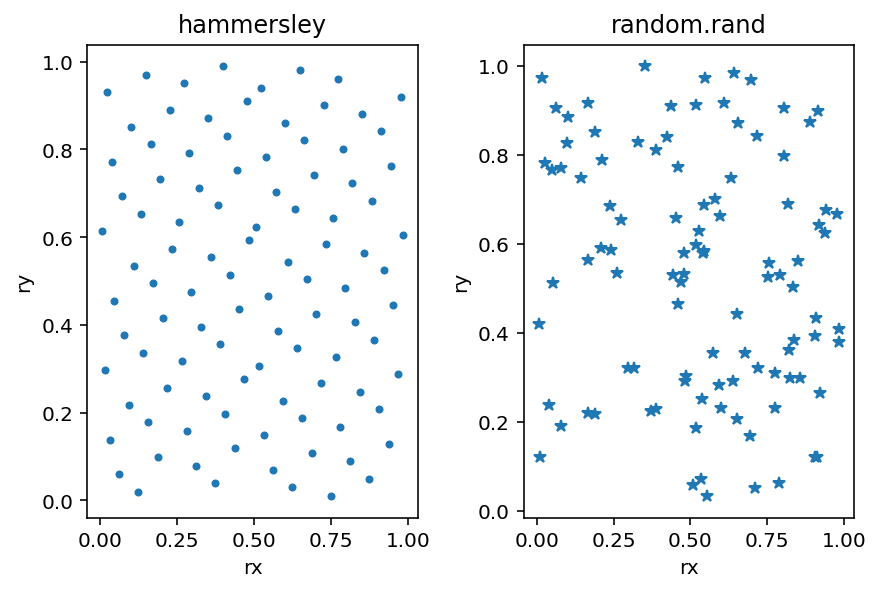

In [3]:
from distgen.dist import random_generator

shape = (2,100)

p1 = random_generator(shape,sequence='hammersley')
p2 = random_generator(shape)

fig, ax = plt.subplots(1, 2, constrained_layout=True)

ax[0].plot(p1[0,:],p1[1,:],'.');
ax[0].set(xlabel='rx', ylabel='ry', title='hammersley');

ax[1].plot(p2[0,:],p2[1,:],'*');
ax[1].set(xlabel='rx', ylabel='ry', title='random.rand');

# 1D Distributions
------

Distgen supports several one dimensional distribution types.

# Uniform 1D 

The uniform distirbuition is defined by a probability distribution function:

$\rho(x) = \frac{1}{b-a}$ for $a\leq x\leq b$ and zero elsewhere.  

The corresponding CDF is

$P(x) = \frac{x-a}{b-a}$ for $a\leq x\leq b$ and zero elsewhere.

The first and second moments of this distribution are:

$\langle x \rangle = \frac{1}{2}(a+b)$ and $\sigma_x = \frac{b-a}{\sqrt{12}}$

uniform
      min_x = 2 mm, max_x = 4 mm


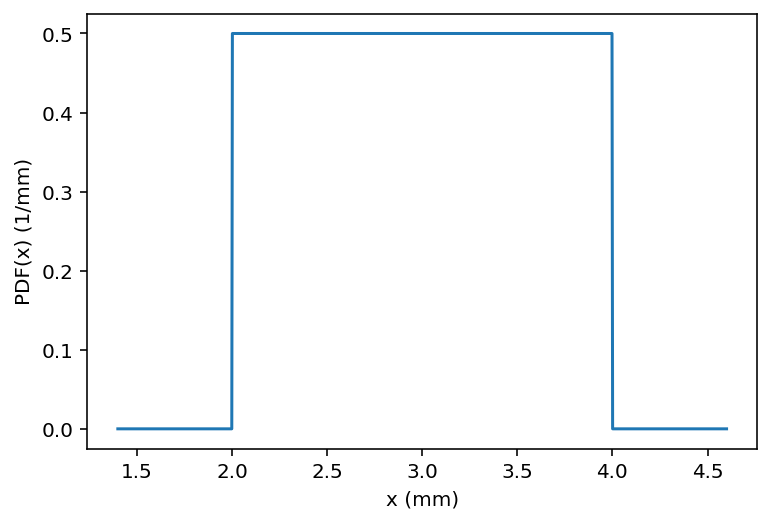

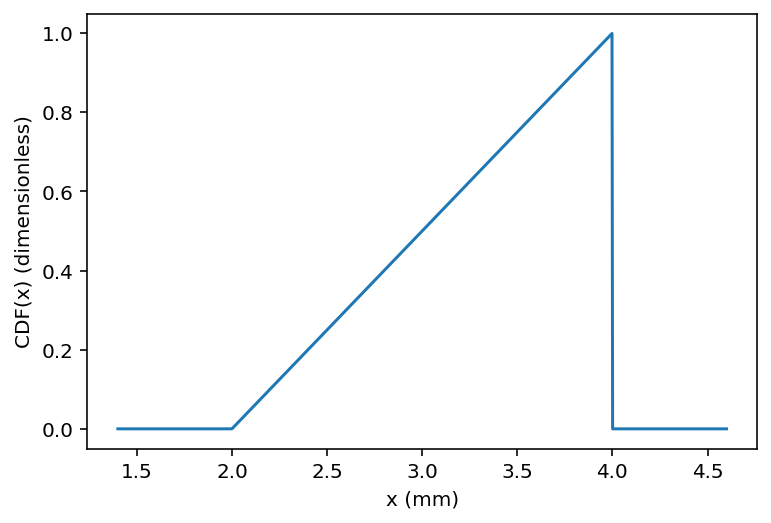

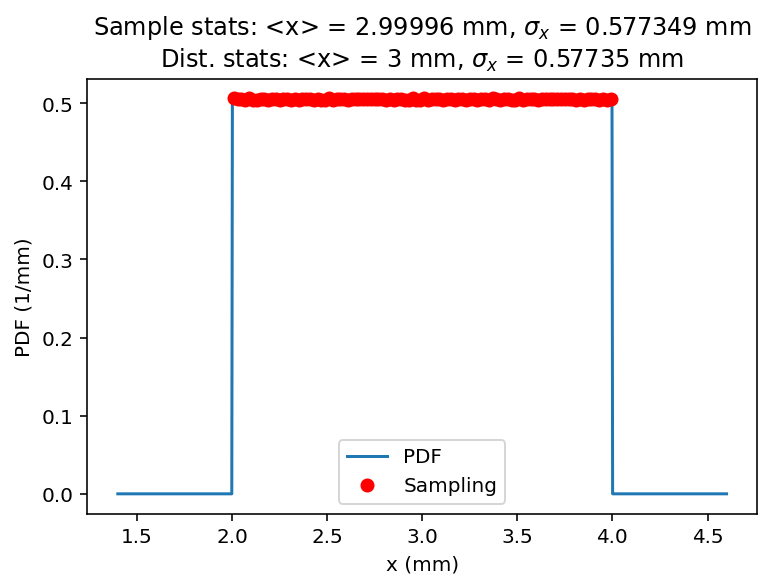

In [4]:
from distgen.dist import Uniform
var = 'x'
verbose=1
params={'min_x':2*unit_registry('mm'),'max_x':4*unit_registry('mm')}
uniform = Uniform(var,verbose=verbose,**params)
uniform.plot_pdf()
uniform.plot_cdf()
uniform.test_sampling()

# Normal Distribution (including truncation)

The general form of a normal distribution PDF with truncation is given by

$\rho(x) = \frac{1}{\sigma}\frac{\phi\left(\frac{x-\mu}{\sigma}\right)}{\Phi\left(\frac{b-\mu}{\sigma}\right)-\Phi\left(\frac{a-\mu}{\sigma}\right)}$.

In this expression $\phi(\xi) = \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}\xi^2}$ is the canonical normal distribution, $\Phi(\xi) = \frac{1}{2}\left[1 + \text{erf}\left(\frac{\xi}{\sqrt{2}}\right) \right]$ is the canonical normal CDF, and $a=-N_{\text{cutoff}}\cdot\sigma$ and $b=-N_{\text{cutoff}}\cdot\sigma$ are the left and right truncation points.  The CDF if given by

$P(x) = \frac{\Phi\left(\frac{x-\mu}{\sigma}\right) - \Phi\left(\frac{a-\mu}{\sigma}\right)}{\Phi\left(\frac{b-\mu}{\sigma}\right)-\Phi\left(\frac{a-\mu}{\sigma}\right)}$.

Defining $\alpha = \frac{a-\mu}{\sigma}$ and $\beta = \frac{b-\mu}{\sigma}$, the first and second moments of the distribution are:

$\langle x\rangle = \mu + \frac{\phi\left(\alpha\right) - \phi\left(\beta\right)}{\Phi\left(\beta\right)-\Phi\left(\alpha\right)}\sigma$ and $\sigma_x = \sigma \left\{1 + \frac{\alpha\phi\left(\alpha\right) - \beta\phi(\beta) }{\Phi(\beta) - \Phi(\alpha)} - \left(\frac{\phi\left(\alpha\right) - \phi(\beta)}{\Phi(\beta) - \Phi(\alpha)}\right)^{2} \right\}^{1/2} $.

When using this distribution, if the $N_{\text{cutoff}}$ is not set then the distribution reduces to an infinite range normal distribution, as first shown below:

Gaussian
      avg_x = -1 mm, sigma_x = 2.000 mm


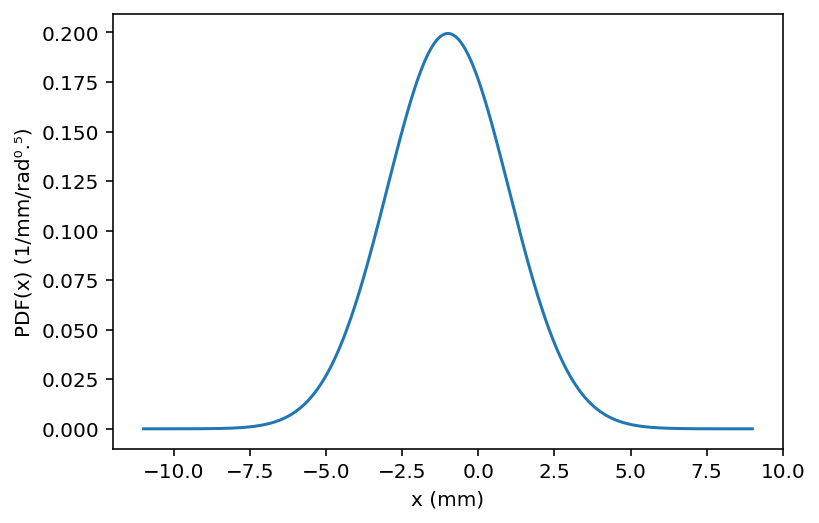

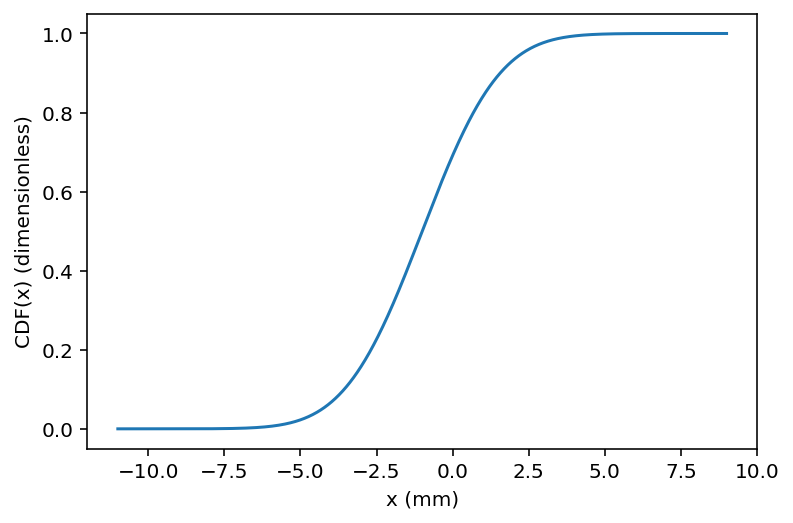

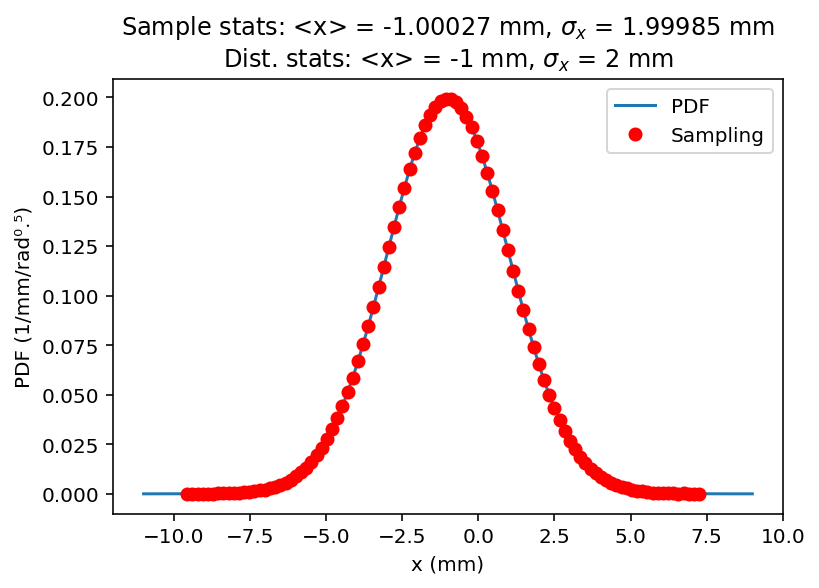

In [5]:
from distgen.dist import Norm
var = 'x'
verbose=1
params={'sigma_x':2*unit_registry('mm'),'avg_x':-1*unit_registry('mm')}
norm = Norm(var,verbose=verbose,**params)
norm.plot_pdf()
norm.plot_cdf()
norm.test_sampling()

Below the $N_{\text{cutoff}}$ parameter is set to cut the distribution symmetrically:

Gaussian
      avg_x = 0 mm, sigma_x = 2.000 mm
      Left n_sigma_cutoff = 2, Right n_sigma_cutoff = -2


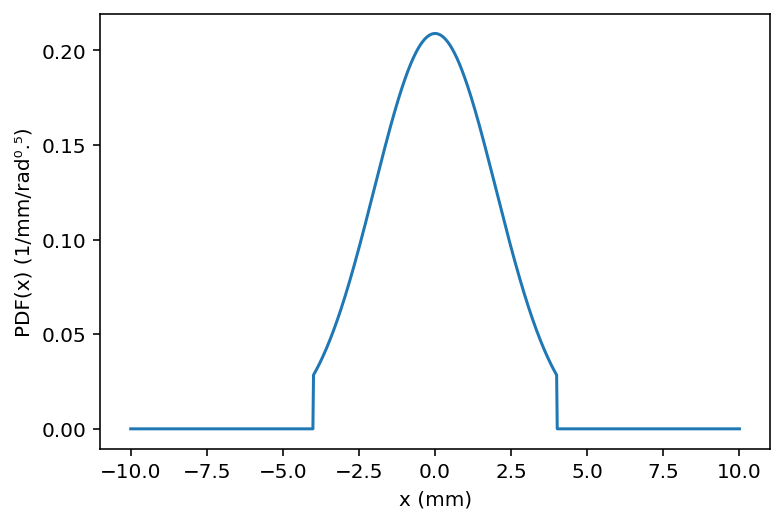

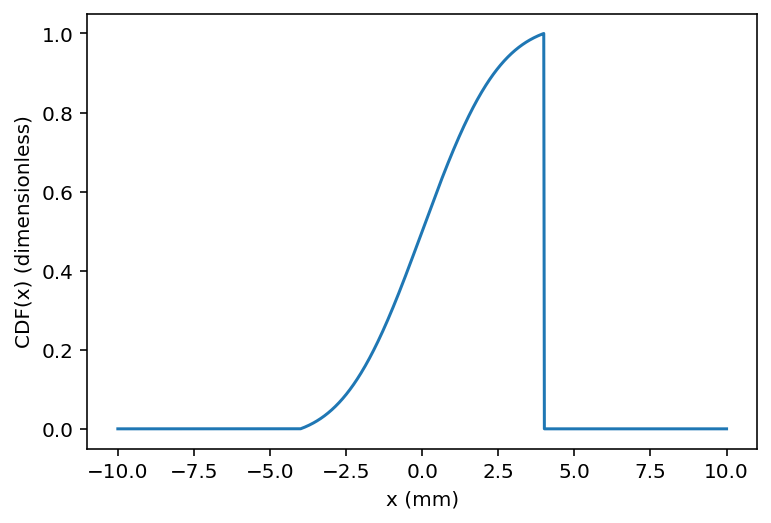

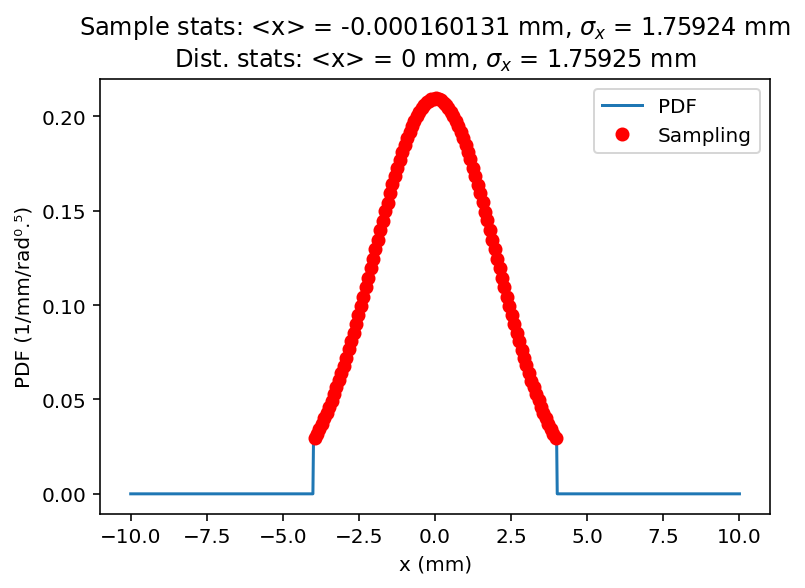

In [6]:
from distgen.dist import Norm
var = 'x'
verbose=1
params={'sigma_x':2*unit_registry('mm'),'avg_x':0*unit_registry('mm'), 'n_sigma_cutoff':2}
norm = Norm(var,verbose=verbose,**params)
norm.plot_pdf()
norm.plot_cdf()
norm.test_sampling()

The distribution can be truncated asymmetrically using the $N_{\text{cutoff},R}$ and $N_{\text{cutoff},L}$ parameters, as shown below.  Note in this case, it is only required that $N_{\text{cutoff},L} < N_{\text{cutoff},R}$, allowing for completley arbtitray location of the truncation points.  This requires a minus sign for the cut off parameters for truncation values less than zero.

Gaussian
      avg_x = 0 mm, sigma_x = 2.000 mm
      Left n_sigma_cutoff = 1, Right n_sigma_cutoff = -1.5


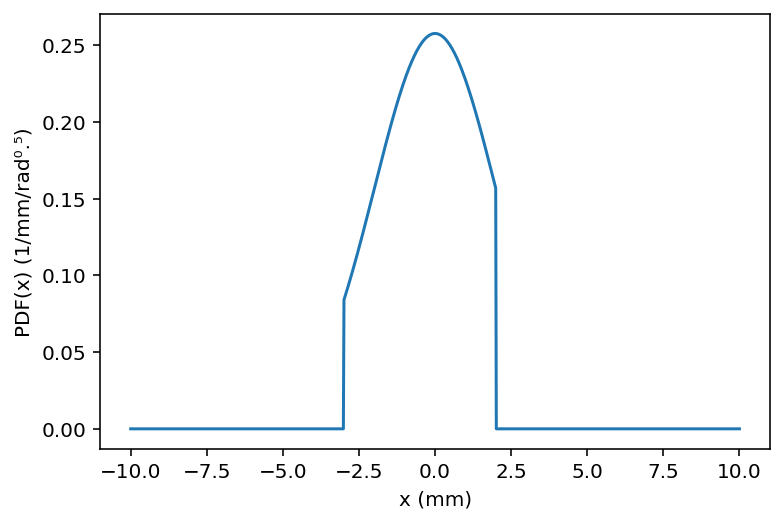

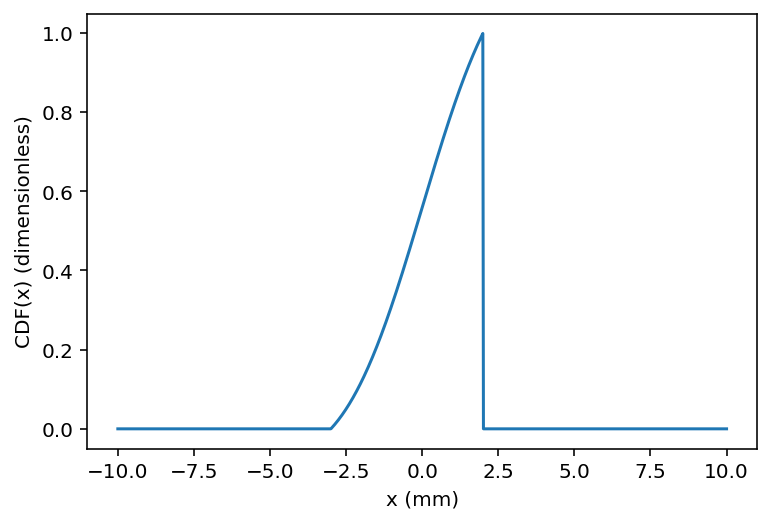

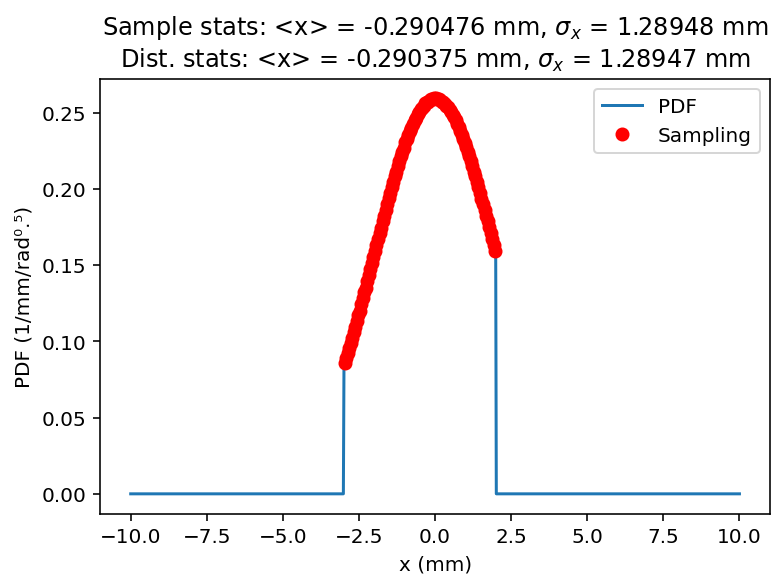

In [7]:
from distgen.dist import Norm
params={'sigma_x':2*unit_registry('mm'),
        'avg_x':0*unit_registry('mm'), 
        'n_sigma_cutoff_left':-1.5,
        'n_sigma_cutoff_right':1}

norm = Norm('x',verbose=1,**params)
norm.plot_pdf()
norm.plot_cdf()
norm.test_sampling()

# Super Gaussian

In additional to the regular Gaussian function, it is also possible to sample a super-Gaussian distribution defined by

$\rho(x; \lambda, p) = \frac{1}{2\sqrt{2}\Gamma\left(1+\frac{1}{2p}\right)\lambda } \exp\left[-\left(\frac{(x-\mu)^2 }{2\lambda^2}\right)^{p}\right]$

Here $\sigma_1$ is the length scale and $p$ is the power of the super-Gaussian. Note when $p=1$ reduces to a Normal distirbution, in which case $\sigma_x=\lambda$.  As $p\rightarrow\infty$ the distribution reduces to a flat-top (uniform). The full range of powers is given by $p\in\left(0,\infty\right]$.  

The first and second moments of the distribution are given by:

$\langle x\rangle = \mu$, and $\sigma_x = \left(\frac{2\Gamma\left(1+\frac{3}{2p}\right)}{3\Gamma\left(1+\frac{1}{2p}\right)}\right)^{1/2}\lambda$.


Often, it is convenient to scan the distribution from the uniform limit to the Gaussian limit.  To do some, the input $p$ can be parameterized by $\alpha\in[0,1]$ where $p = 1/\alpha$.  Here $\alpha=0$ corresponds to a flat-top (uniform) and $\alpha=1$ corresponds to a Gaussian.  Examples of both types of usage are shown below.

In [8]:
from distgen.dist import SuperGaussian

ps = [0.5, 1 , 5, float('Inf')]
alphas = [0, 0.25, 0.5, 1]

fig, (ax1, ax2) = plt.subplots(1, 2,
                               sharex='col',
                               figsize=(12,4),
                               constrained_layout=True)

plegs = ['p = '+str(p) for p in ps]
alegs = ['$\\alpha$ = '+str(a) for a in alphas]

for ii,p in enumerate(ps):
    pparams = {'lambda':2*unit_registry('mm'),
              'p':p*unit_registry('dimensionless'),}
    
    supG = SuperGaussian('x',verbose=0,**pparams)
    x = supG.get_x_pts(1000)
    rho = supG.pdf(x)
    ax1.plot(x,rho);
    
    a=alphas[ii]
    aparams = {'lambda':2*unit_registry('mm'),
              'alpha':a*unit_registry('dimensionless'),}
    
    x = np.linspace(-3*aparams['lambda'], 3*aparams['lambda'],100)
    supG = SuperGaussian('x',verbose=0,**aparams)
    rho = supG.pdf(x)
    ax2.plot(x,rho);
    
ax1.set_xlabel('x (mm)');    ax2.set_xlabel('x (mm)');
ax1.set_ylabel('pdf (1/mm)');ax2.set_ylabel('pdf (1/mm)');
ax1.legend(plegs);           ax2.legend(alegs);

To set the length scale of the distribution, the user must either supply 'sigma_[var]' or 'lambda'. See usage below:

Super Gaussian
      simga_x = 2 mm, power = 333.333


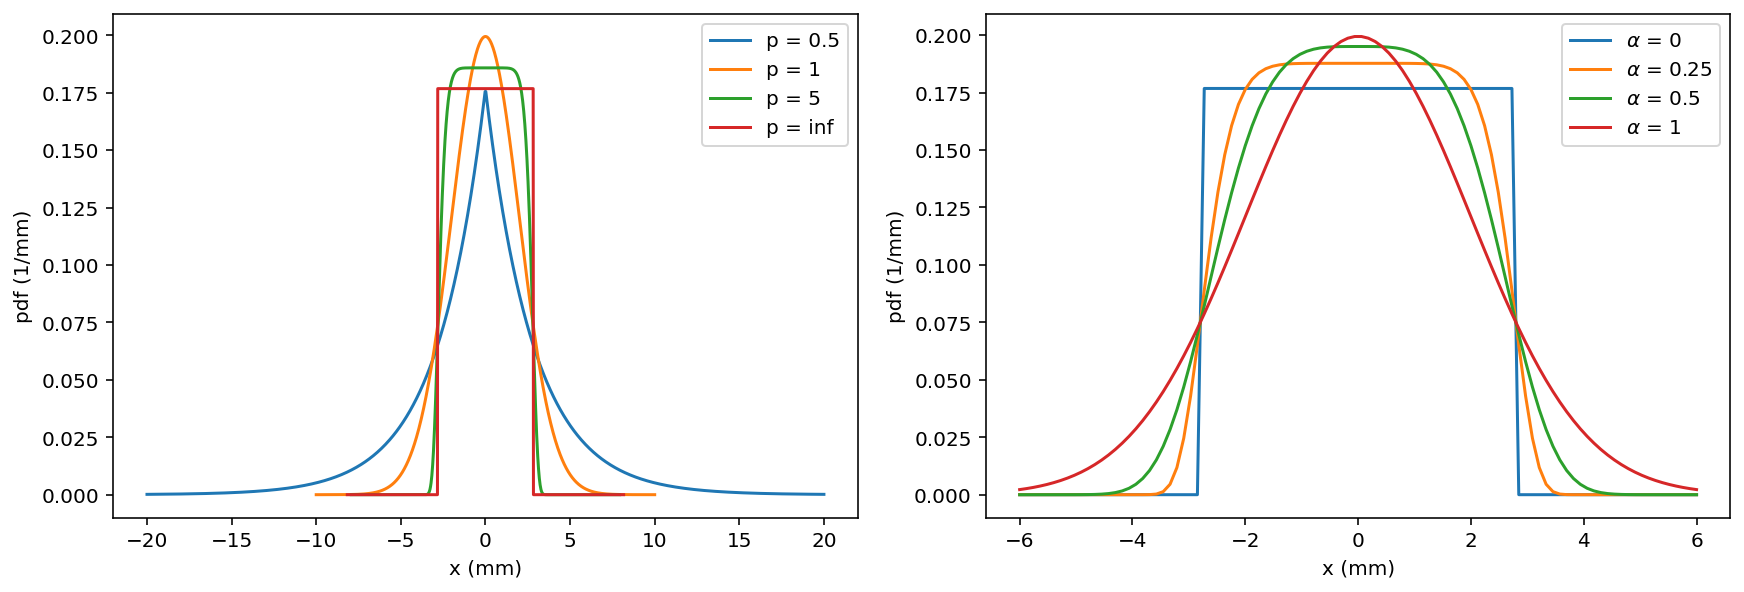

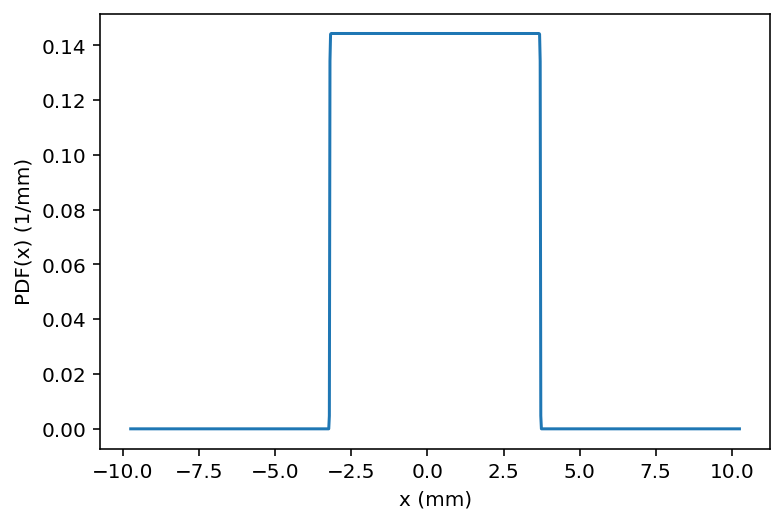

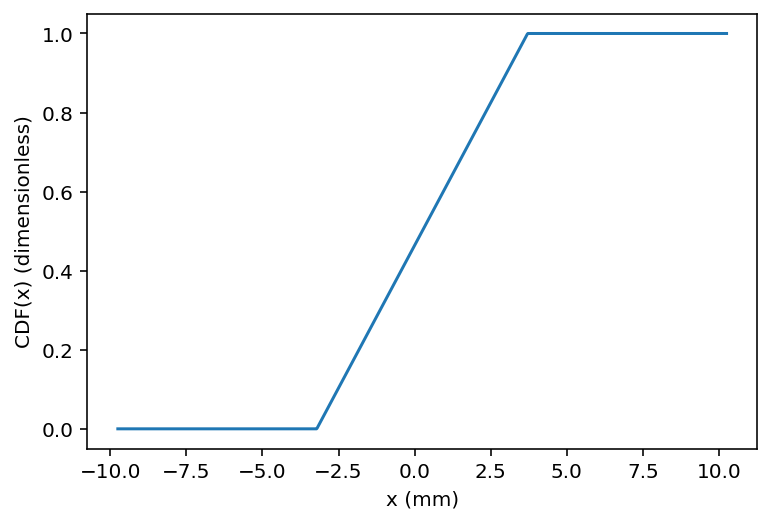

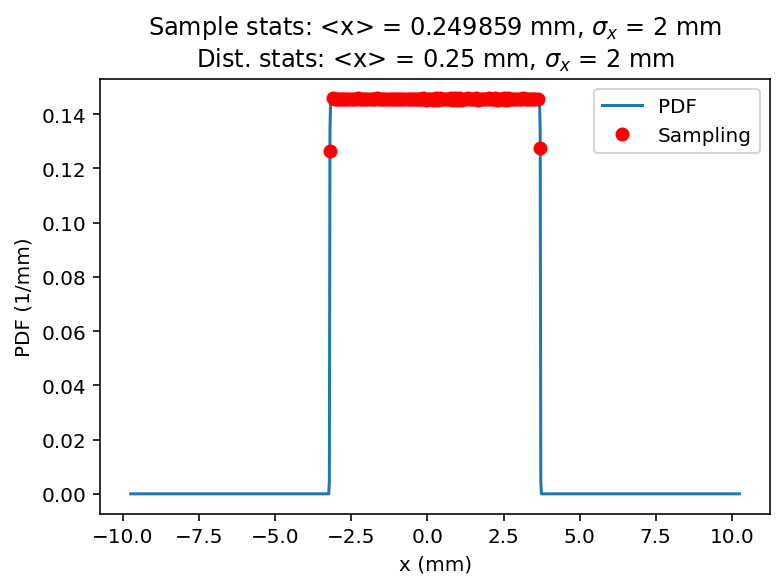

In [9]:
params = {'sigma_x':2*unit_registry('mm'),
          #'alpha': 0.75*unit_registry('dimensionless'),
           'alpha': 0.003*unit_registry('dimensionless'),
          'avg_x':0.25*unit_registry('mm')}

supG = SuperGaussian('x',verbose=1,**params)
supG.plot_pdf()
supG.plot_cdf()
supG.test_sampling()

# 1D PDF from a file

Disgten supports importing a 1D PDF saved in column form in.  The input form of the file should have space separated headers such as $x$ and $Px$, with corresponding column data below it.  The PDF is normalized numerically using the numpy.trapz numerical integration routine. The CDF is computed using the scipy.cumtrapz cumulative numerical intgration routine.

The following example shows a gaussian PDF with cuts added to it.

t-distribution file: "../examples/data/cutgauss.1d.txt"


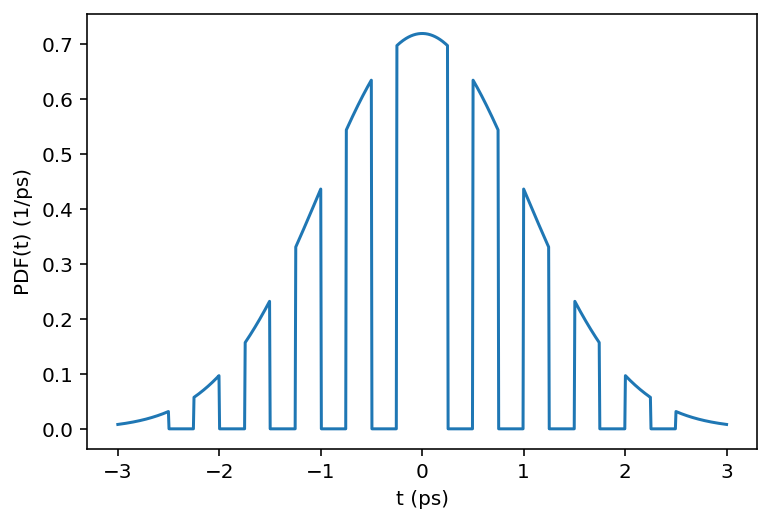

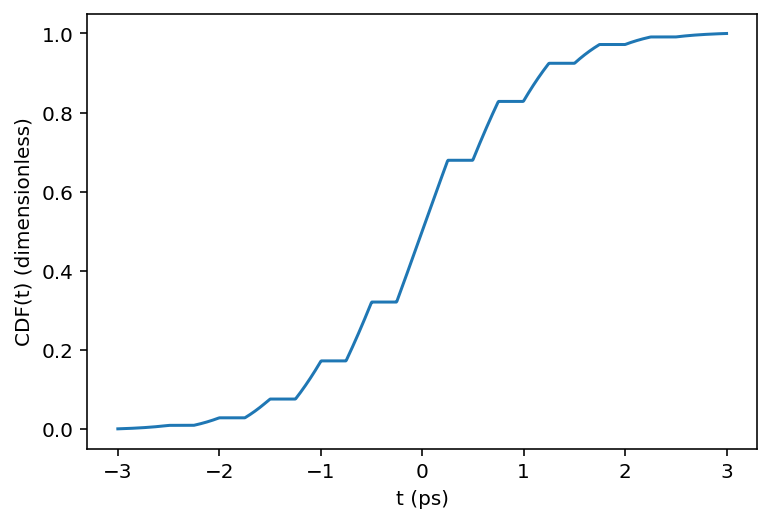

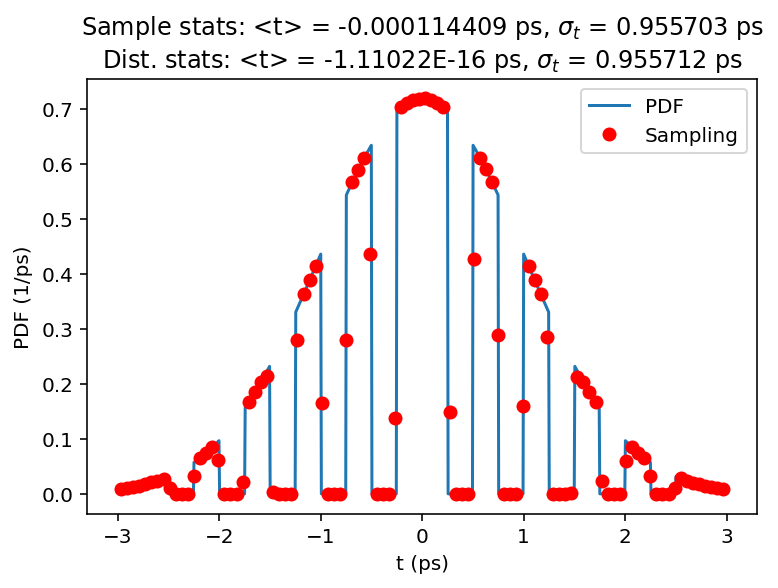

In [10]:
from distgen.dist import File1d
var = 't'
verbose=1
params={'file':'../examples/data/cutgauss.1d.txt','units':'ps'}
file1d = File1d(var,verbose=verbose,**params)
file1d.plot_pdf()
file1d.plot_cdf()
file1d.test_sampling()

# Laser pulse stacking 

crystal temporal laser shaping
      crystal 1 length = 15.096 mm, angle = 0.6 deg
      crystal 2 length = 7.548 mm, angle = 1.8 deg
      crystal 3 length = 3.774 mm, angle = -0.9 deg
      crystal 4 length = 1.887 mm, angle = -0.5 deg
      Pulses propagated: min t = -23.9053 ps, max t = 23.9053 ps


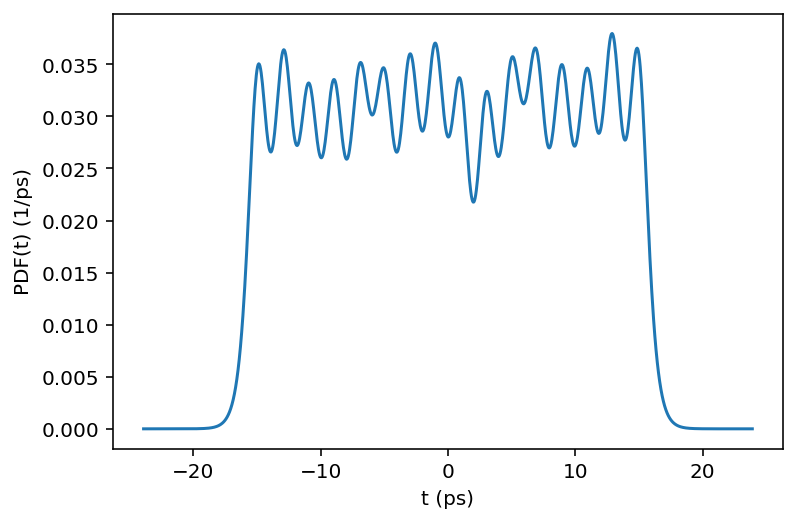

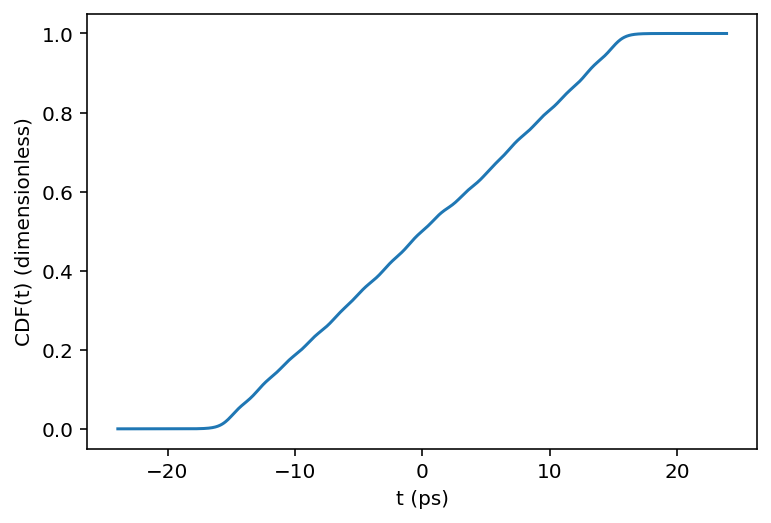

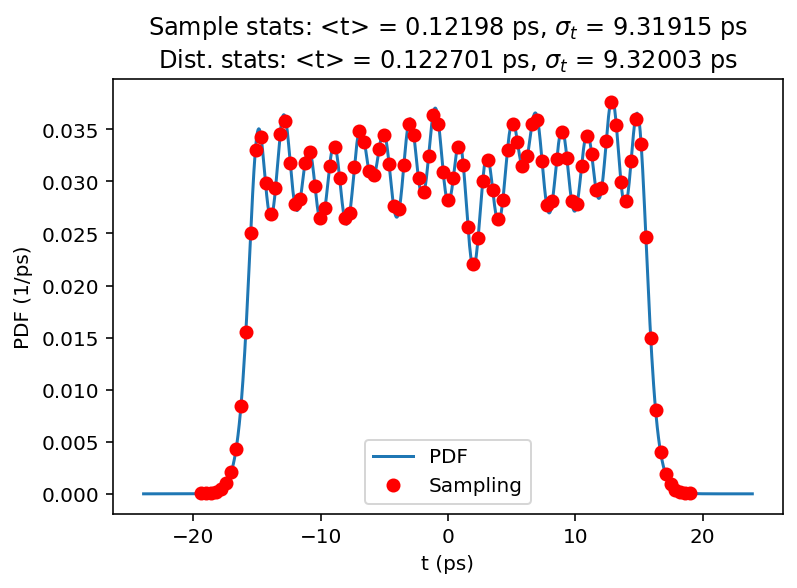

In [11]:
from distgen.dist import TemporalLaserPulseStacking
verbose=1
params={'crystal_length_1': 15.096*unit_registry('mm'),
        'crystal_length_2': 7.548*unit_registry('mm'), 
        'crystal_length_3': 3.774*unit_registry('mm'), 
        'crystal_length_4': 1.887*unit_registry('mm'), 
        'crystal_angle_1':  0.6*unit_registry('deg'), 
        'crystal_angle_2':  1.8*unit_registry('deg'), 
        'crystal_angle_3': -0.9*unit_registry('deg'),  
        'crystal_angle_4': -0.5*unit_registry('deg'), }
    
laser_pulse = TemporalLaserPulseStacking(verbose=verbose,**params)
laser_pulse.plot_pdf()
laser_pulse.plot_cdf()
laser_pulse.test_sampling()

# Tukey 1D

Tukey
      legnth = 2 mm, ratio = 0.75


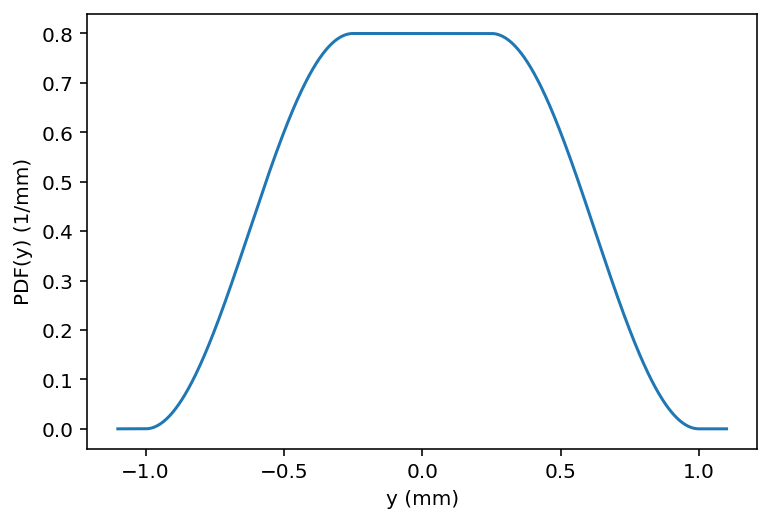

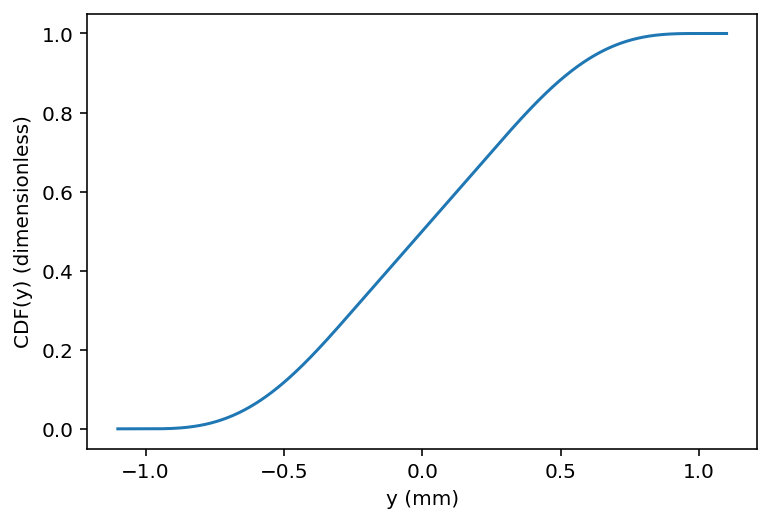

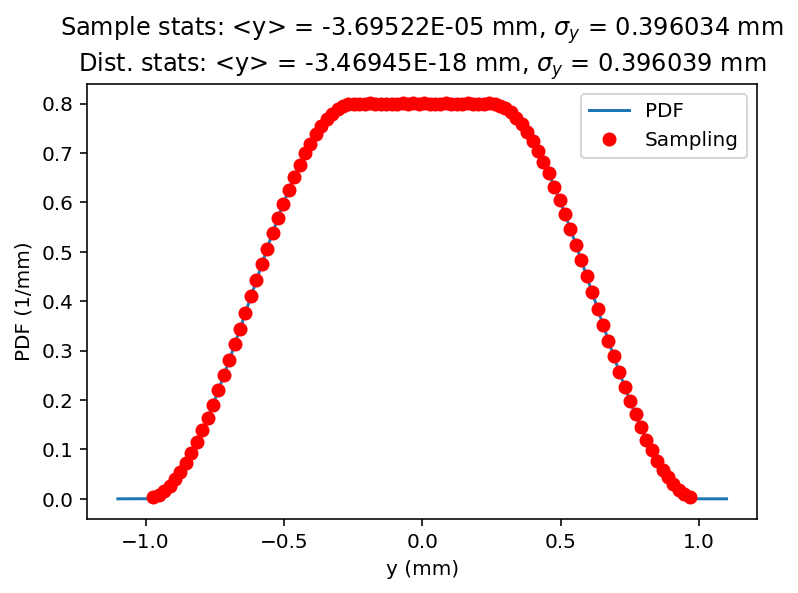

In [12]:
from distgen.dist import Tukey
var = 'y'
verbose=1
params={'length':2*unit_registry('mm'),'ratio':0.75*unit_registry('dimensionless')}
tukey = Tukey(var,verbose=1,**params)
tukey.plot_pdf()
tukey.plot_cdf()
tukey.test_sampling()

# Superposition 1D
This distribution allows the user to superimpose an arbitrary number of 1D PDFs.  The general form is:

$\rho(x) = \sum_i w_i \frac{\rho_i(x)}{\max(\rho_i)}$


distribution name: d1
Gaussian
      avg_z = -2 mm, sigma_z = 1.000 mm

distribution name: d2
Gaussian
      avg_z = 2 mm, sigma_z = 1.000 mm


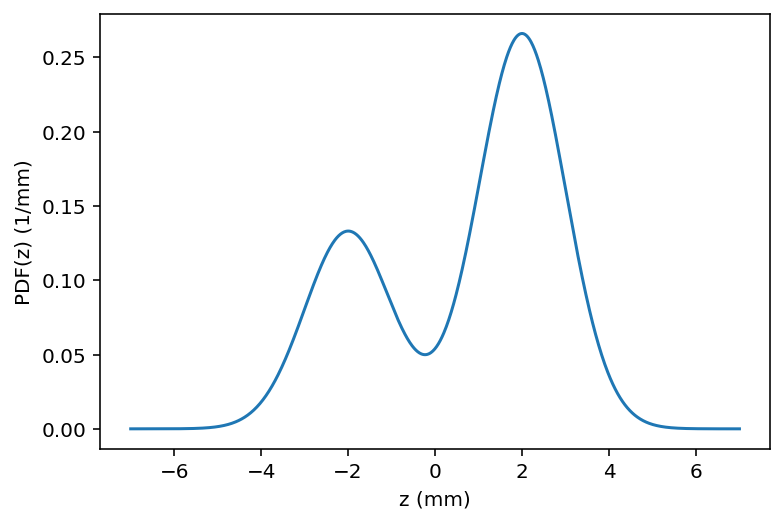

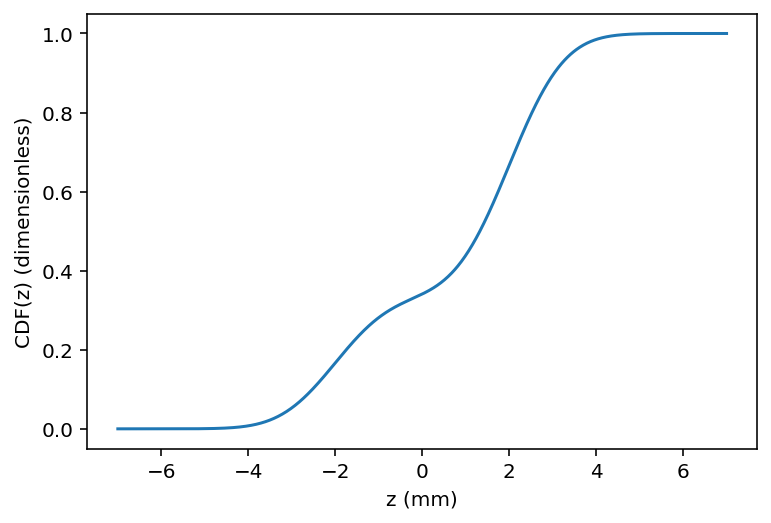

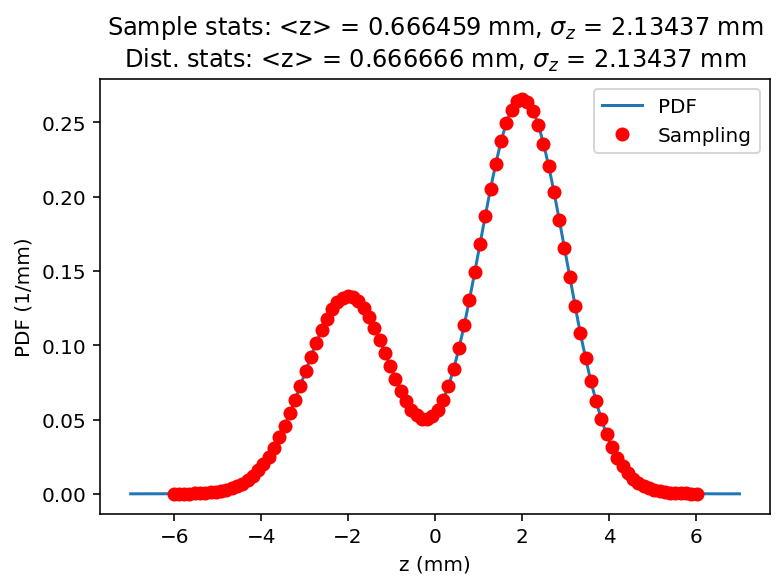

In [18]:
from distgen.dist import Superposition

params = {
    'weights':{'d1':1, 'd2':2},
    'dists':{
        'd1':{
            'avg_z':-2*unit_registry('mm'),
            'sigma_z':1*unit_registry('mm'),
            'type': 'gaussian'
        } ,
        'd2':{
            'avg_z':+2*unit_registry('mm'),
            'sigma_z':1*unit_registry('mm'),
            'type': 'gaussian'
        } 
    }
}

sup = Superposition('z', 1, **params)
sup.plot_pdf()
sup.plot_cdf()
sup.test_sampling()

# Radial Distributions
---

In [ ]:
from distgen.dist import UniformRad
verbose=1
params={'min_r':1*unit_registry('mm'),'max_r':2*unit_registry('mm')}
urad = UniformRad(verbose=1,**params)
urad.plot_pdf()
urad.plot_cdf()
urad.test_sampling()

# Radial Normal Distribution (with truncation)

The radial normal distribution including truncation(s) has a probability function given by

$\rho_r(r) = \frac{1}{\sigma^2}\frac{\phi(r/\sigma)}{\phi\left(\frac{r_L}{\sigma}\right)-\phi\left(\frac{r_R}{\sigma}\right)} $ for $0 \leq r_L \leq r \leq r_R$ and zero everywhere else.

In this expresion $\phi(\xi) = \frac{1}{2\pi}\exp\left(-\xi^2/2\right)$ is the canonical raidial normal distirbution (no truncation), and the scale parameter $\sigma$ follows from the product of two normal distributions in $x$ and $y$ when $\sigma=\sigma_x=\sigma_y$.  The corresponding CDF is given by

$P(r)= \frac{\phi\left(\frac{r_L}{\sigma}\right)-\phi\left(\frac{r}{\sigma}\right)}{\phi\left(\frac{r_L}{\sigma}\right)-\phi\left(\frac{r_R}{\sigma}\right)} $ for $0 \leq r_L \leq r$.

The corresponding first and second moments are:

$\langle r\rangle = \frac{\frac{r_L}{\sigma}\phi\left(\frac{r_L}{\sigma}\right)
-\frac{r_R}{\sigma}\phi\left(\frac{r_R}{\sigma}\right)
+\frac{1}{2\sqrt{2\pi}}\left( \text{erf}\left(\frac{r_R}{\sigma\sqrt{2}}\right) - \text{erf}\left(\frac{r_L}{\sigma\sqrt{2}}\right) \right) 
}
{\phi\left(\frac{r_L}{\sigma}\right)-\phi\left(\frac{r_R}{\sigma}\right)}$,

$r_{rms} = \sqrt{ 2\sigma^2 + r_L^2 - \frac{(r_R^2-r_L^2)\phi(r_R/\sigma)}{\phi\left(\frac{r_L}{\sigma}\right)-\phi\left(\frac{r_R}{\sigma}\right)} }$.

Note that in the limits $r_L\rightarrow 0$ and $r_R -> \infty$ the above expressions reduce to the underlying radial normal distribution:

$\rho_r(r)\rightarrow \frac{\phi\left(\frac{r}{\sigma}\right)}{\sigma^2}$, $P(r)\rightarrow 1 - \phi\left(\frac{r}{\sigma}\right)$, $\langle r\rangle\rightarrow \sqrt{\frac{\pi}{2}}\sigma$, and $r_{rms}\rightarrow \sqrt{2}\sigma$.  This limiting case is shown first below.


In [ ]:
from distgen.dist import NormRad
verbose=1
params={'sigma_xy':1*unit_registry('mm')}
nrad = NormRad(verbose=1,**params)
nrad.plot_pdf()
nrad.plot_cdf()
nrad.test_sampling()

For laser scientists it can be convenient to to work with a pinhole radius and a fraction of the laser intensity to clip a transverse normal laser mode at.  In this case the user can supply a truncation radius ($=r_R$) and a truncation fraction $f = \exp\left(-\frac{r_R^2}{2\sigma}\right)$ from which distgen determines the underlying $\sigma$.  The example below demonstrates this usage:

In [ ]:
from distgen.dist import NormRad
verbose=1
params={'truncation_radius':1*unit_registry('mm'),'truncation_fraction':0.5*unit_registry('dimensionless')}
nrad = NormRad(verbose=1,**params)
nrad.plot_pdf()
nrad.plot_cdf()
nrad.test_sampling()

In [ ]:
from distgen.dist import NormRad
verbose=1
params={'sigma_xy':2*unit_registry('mm'),'n_sigma_cutoff':1}
nrad = NormRad(verbose=1,**params)
nrad.plot_pdf()
nrad.plot_cdf()
nrad.test_sampling()

# Radial Tukey

In [ ]:
from distgen.dist import TukeyRad
verbose=1
params={'length':1*unit_registry('mm'),'ratio':0.75*unit_registry('dimensionless')}
rtukey = TukeyRad(verbose=1,**params)
rtukey.plot_pdf()
rtukey.plot_cdf()
rtukey.test_sampling()

# Radial Super Gaussian
This implements a radial version of the Super Gaussian function discussed above.  Here the radial function takes the form:

$2\pi\rho(r;\lambda,p) = \frac{1}{\Gamma\left(1+\frac{1}{p}\right)\lambda^2} \exp\left[-\left(\frac{r^2}{2\lambda^2}\right)^p\right]$. The corrsponding CDF is: ?

The first and (rms) second moment of the distribution are given by:

$\langle r\rangle = \frac{2\sqrt{2}}{3}\frac{\Gamma\left(1+\frac{3}{2p}\right)}{\Gamma\left(1+\frac{1}{p}\right)}\lambda$, 

$r_{\text{rms}} = \sqrt{\frac{\Gamma\left(1+\frac{2}{p}\right)}{\Gamma\left(1+\frac{1}{p}\right)}}\lambda$.


In [ ]:
from distgen.dist import SuperGaussianRad
verbose=1
params={'sigma_xy':1*unit_registry('mm'),
        'alpha':0.50*unit_registry('dimensionless')}
supG = SuperGaussianRad(verbose=1,**params)
supG.plot_pdf()
supG.plot_cdf()
supG.test_sampling()

# Radial File Distribution

In [ ]:
from distgen.dist import RadFile

params = {'file':'../examples/data/cutgauss.rad.txt','units':'mm'}

rfd = RadFile(verbose=1, **params)
rfd.plot_pdf()
rfd.plot_cdf()
rfd.test_sampling()

# Angular Distributions (TODO)
---
Angular distributions define one dimensional probability functions for the cylindrical variable $\theta$.  